/var/folders/rs/2gfhs5rx3y98jjkwk65m3byc0000gn/T/ipykernel_80841/435144222.py:36: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start, periods=len(data), freq='5T')


Training Rule1 score is: 0.423
Training Rule2 score is: 0.423
Training Rule3 score is: 0.451
Training Rule4 score is: 0.424
Training Rule5 score is: 0.402
Training Rule6 score is: 0.448
Training Rule7 score is: 0.454
Training Rule8 score is: 0.371
Training Rule9 score is: 0.453
Training Rule10 score is: 0.461
Training Rule11 score is: 0.363
Training Rule12 score is: 0.458
Training Rule13 score is: 0.363
Training Rule14 score is: 0.239
Training Rule15 score is: 0.173
Training Rule16 score is: 0.117


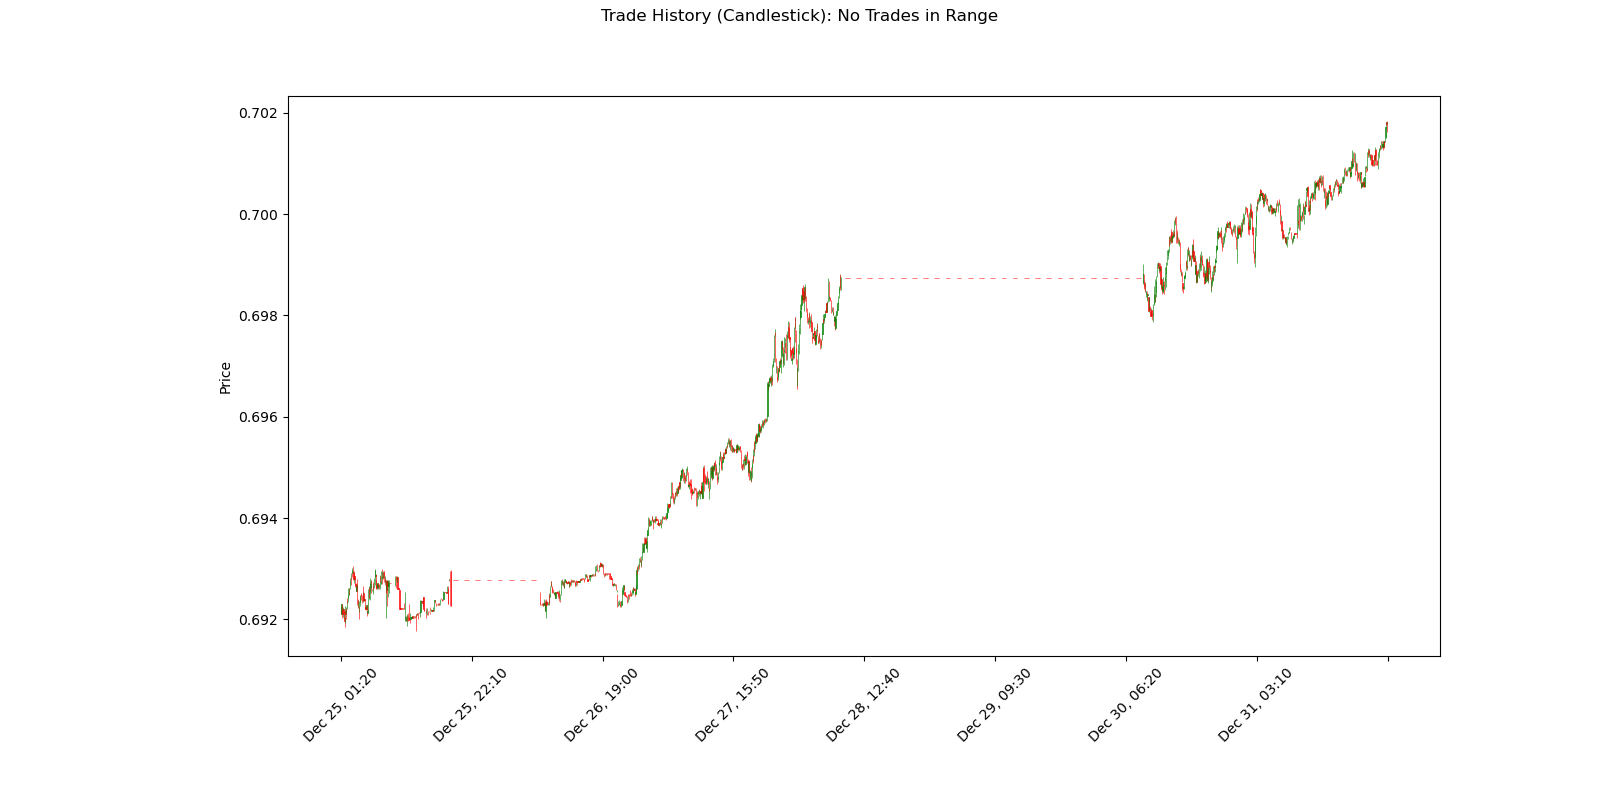


Training Data Evaluation:
----------------------------------------
Position Metrics (Log-return based):
Maximum Position: 1.000
Mean Position   : 0.521
Total Return    : 25.70%
Max Drawdown    : -0.890%
Sharpe Ratio    : 9.104
----------------------------------------
----------------------------------------
Training Trade Metrics
----------------------------------------
Number of Trades    : 13102
Avg Holding Period  : 4.01 timesteps
Win Rate            : 44.76%
Avg PNL per Trade   : $15.60
% Return on 1M     : 20.44%
Avg Pips (Wins)     : 1.60 pips
Avg Pips (Losses)   : -1.02 pips
Trade Range         : Index 0 to 52558
----------------------------------------

Testing Data Evaluation:
----------------------------------------
Position Metrics (Log-return based):
Maximum Position: 0.847
Mean Position   : 0.577
Total Return    : 15.53%
Max Drawdown    : -0.192%
Sharpe Ratio    : 6.372
----------------------------------------
----------------------------------------
Testing Trade Metrics

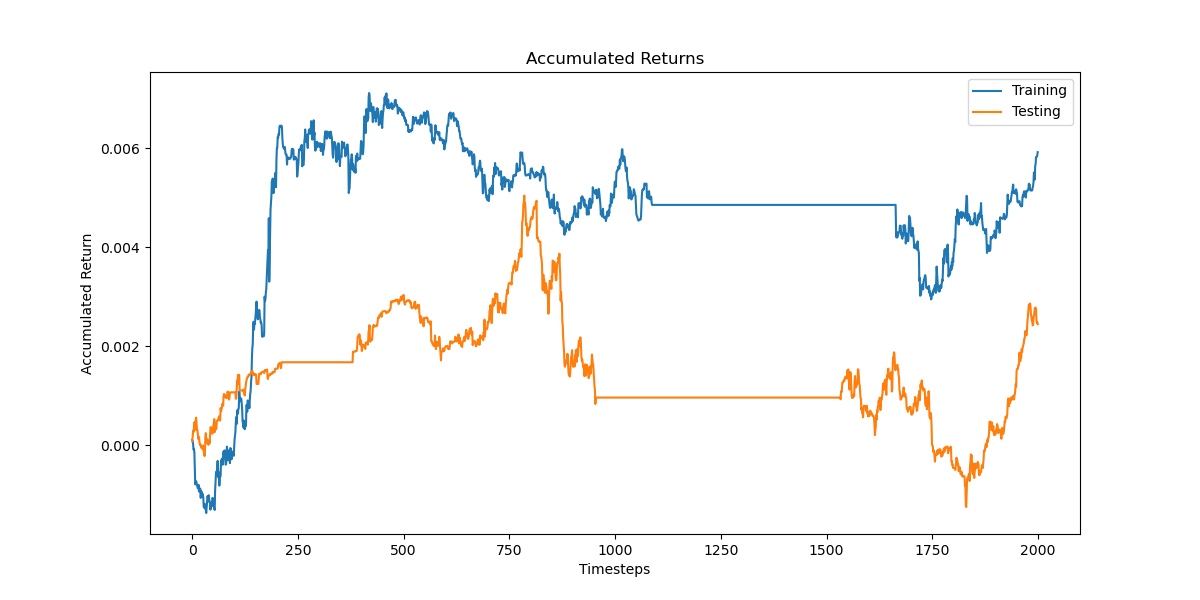

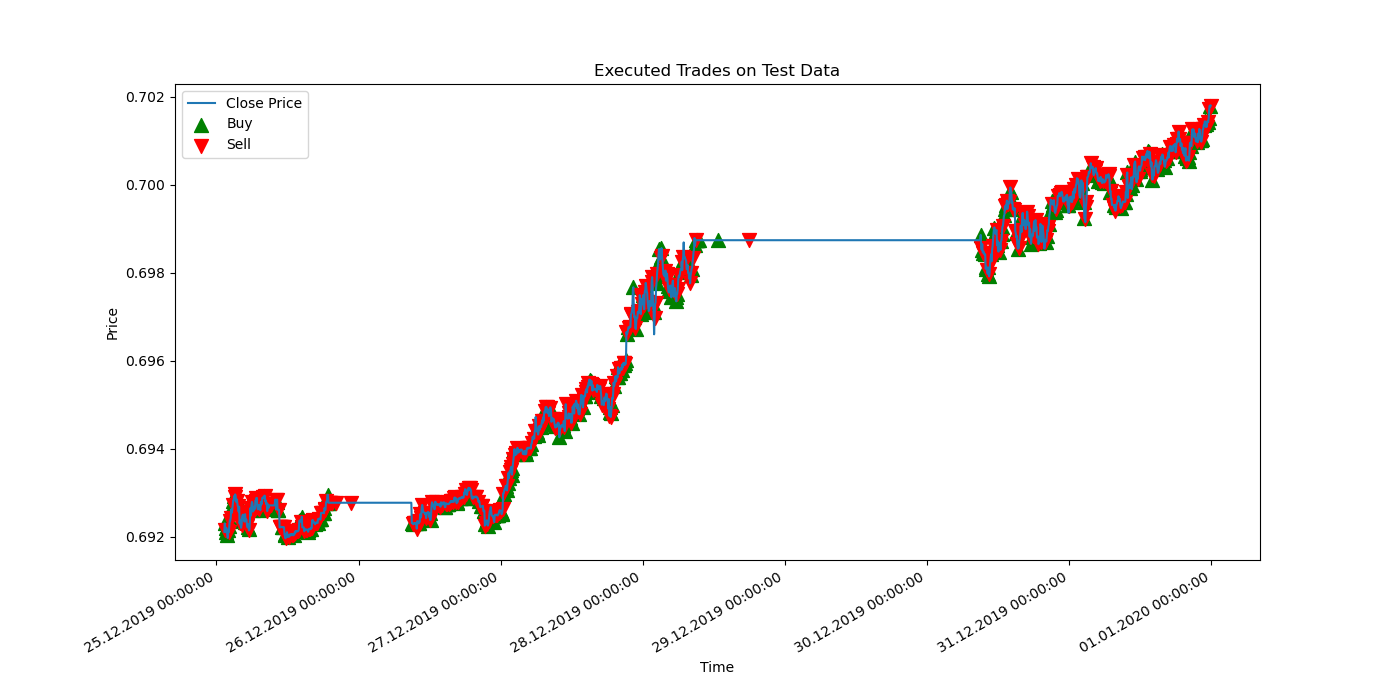

In [18]:
# Main_notebook.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import mplfinance as mpf

from ga import GA_train
from tradingrule import trainTradingRuleFeatures, getTradingRuleFeatures

# ANSI escape sequences for colored terminal output
BOLD_GREEN  = "\033[1;32m"
BOLD_CYAN   = "\033[1;36m"
BOLD_YELLOW = "\033[1;33m"
RESET       = "\033[0m"
LINE        = "----------------------------------------"

# =====================================================
# Data Loading and Splitting Functions
# =====================================================
def load_data(csv_path: str) -> pd.DataFrame:
    """
    Loads OHLC data from a CSV file.
    If a "Date" column exists, parse it; otherwise, create a synthetic datetime index assuming 5-minute intervals.
    Keeps only the columns: ['Date' (if present), 'Open', 'High', 'Low', 'Close'].
    """
    data = pd.read_csv(csv_path)
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
        data.set_index('Date', inplace=True)
    else:
        # Create synthetic datetime index (assume 5-minute intervals starting at Jan 1, 2019)
        start = datetime(2019, 1, 1)
        date_range = pd.date_range(start, periods=len(data), freq='5T')
        data.index = date_range
    data = data[['Open', 'High', 'Low', 'Close']]
    data.sort_index(inplace=True)
    return data

def split_data(data: pd.DataFrame):
    """
    Splits data into training and testing sets (50/50).
    """
    split_index = len(data) // 2
    X_train = data.iloc[:split_index].copy()
    X_test  = data.iloc[split_index:].copy()
    return X_train, X_test

# =====================================================
# Evaluation and Trade Metrics Functions
# =====================================================
def evaluate(position: np.ndarray, logr: pd.Series):
    """
    Prints key performance metrics based on log returns.
    (PNL is computed from log returns, and the Sharpe Ratio is annualized here.)
    """
    port_r = logr * position
    max_pos = position.max()
    mean_pos = abs(position).mean()
    total_return = port_r.sum() * 100
    max_drawdown = min(port_r.cumsum()) * 100

    print(f"{BOLD_GREEN}{LINE}{RESET}")
    print(f"{BOLD_CYAN}Position Metrics (Log-return based):{RESET}")
    print(f"Maximum Position: {max_pos:.3f}")
    print(f"Mean Position   : {mean_pos:.3f}")
    print(f"Total Return    : {total_return:.2f}%")
    print(f"Max Drawdown    : {max_drawdown:.3f}%")
    
    # Annualized Sharpe Ratio assuming 5min data: (252*24*12 periods per year)
    sr = port_r.mean() / port_r.std() if port_r.std() != 0 else 0
    annual_factor = (252 * 24 * 12) ** 0.5
    print(f"Sharpe Ratio    : {(sr * annual_factor):.3f}")
    print(f"{BOLD_GREEN}{LINE}{RESET}")

def compute_trade_metrics(positions: np.ndarray, prices: pd.Series) -> dict:
    """
    Computes trade-level metrics based on a trade history derived from positions and prices.
    A trade is defined as a period of contiguous nonzero positions.
    For each trade, we calculate:
      - Holding period (in timesteps)
      - Pips difference and PNL (assuming 1M AUD where 1 pip = 0.0001 change yields $100)
    Returns a dictionary with:
      - Number of trades
      - Average holding period
      - Win rate
      - Average PNL per trade
      - Total % return on 1M
      - Average pips gained (wins) and lost (losses)
      - Start and end indices
      - The full trade history DataFrame
    """
    pip_size = 0.0001
    cash_per_pip = 100  # For a 1M AUD position
    
    pos_sign = np.sign(positions)
    change_indices = np.where(np.diff(pos_sign) != 0)[0] + 1
    trade_starts = np.concatenate(([0], change_indices))
    trade_ends = np.concatenate((change_indices, [len(positions)]))
    
    trades = []
    for start, end in zip(trade_starts, trade_ends):
        if positions[start] == 0:
            continue
        holding_period = end - start
        direction = 'Long' if positions[start] > 0 else 'Short'
        entry_price = prices.iloc[start]
        exit_price = prices.iloc[end - 1]
        if direction == 'Long':
            pips = (exit_price - entry_price) / pip_size
        else:
            pips = (entry_price - exit_price) / pip_size
        pnl = pips * cash_per_pip
        trades.append({
            'Entry_Index': start,
            'Exit_Index': end - 1,
            'Entry_Price': entry_price,
            'Exit_Price': exit_price,
            'Direction': direction,
            'Holding_Period': holding_period,
            'Pips': pips,
            'PNL': pnl
        })
    
    if len(trades) == 0:
        return {}
    
    trades_df = pd.DataFrame(trades)
    win_trades = trades_df[trades_df['PNL'] > 0]
    loss_trades = trades_df[trades_df['PNL'] <= 0]
    
    metrics = {
        'num_trades': len(trades_df),
        'avg_holding_period': trades_df['Holding_Period'].mean(),
        'win_rate': len(win_trades) / len(trades_df),
        'avg_pnl': trades_df['PNL'].mean(),
        '% return': trades_df['PNL'].sum() / 1e6 * 100,  # % return on 1M base
        'avg_pips_win': win_trades['Pips'].mean() if not win_trades.empty else 0,
        'avg_pips_loss': loss_trades['Pips'].mean() if not loss_trades.empty else 0,
        'start_index': trades_df['Entry_Index'].min(),
        'end_index': trades_df['Exit_Index'].max(),
        'trade_history': trades_df  # include the full trade history
    }
    return metrics

def print_trade_metrics(metrics: dict, title: str = "Trade Metrics"):
    """
    Pretty-prints trade metrics with colors and boxed sections.
    """
    if not metrics:
        print("No trades detected.")
        return
    print(f"{BOLD_YELLOW}{LINE}{RESET}")
    print(f"{BOLD_YELLOW}{title}{RESET}")
    print(f"{BOLD_YELLOW}{LINE}{RESET}")
    print(f"{BOLD_CYAN}Number of Trades    :{RESET} {metrics['num_trades']}")
    print(f"{BOLD_CYAN}Avg Holding Period  :{RESET} {metrics['avg_holding_period']:.2f} timesteps")
    print(f"{BOLD_CYAN}Win Rate            :{RESET} {metrics['win_rate']*100:.2f}%")
    print(f"{BOLD_CYAN}Avg PNL per Trade   :{RESET} ${metrics['avg_pnl']:.2f}")
    print(f"{BOLD_CYAN}% Return on 1M     :{RESET} {metrics['% return']:.2f}%")
    print(f"{BOLD_CYAN}Avg Pips (Wins)     :{RESET} {metrics['avg_pips_win']:.2f} pips")
    print(f"{BOLD_CYAN}Avg Pips (Losses)   :{RESET} {metrics['avg_pips_loss']:.2f} pips")
    print(f"{BOLD_CYAN}Trade Range         :{RESET} Index {metrics['start_index']} to {metrics['end_index']}")
    print(f"{BOLD_YELLOW}{LINE}{RESET}")

# =====================================================
# Trade History Generation and Plotting Functions
# =====================================================
def generate_trade_history(prices: pd.Series, positions: np.ndarray) -> pd.DataFrame:
    """
    Generates a trade history DataFrame from the given prices and positions.
    Records entry/exit times, prices, direction, holding period, pip change, and PNL.
    """
    pip_size = 0.0001
    cash_per_pip = 100  # for 1M AUD
    
    pos_sign = np.sign(positions)
    change_indices = np.where(np.diff(pos_sign) != 0)[0] + 1
    trade_starts = np.concatenate(([0], change_indices))
    trade_ends = np.concatenate((change_indices, [len(positions)]))
    
    trades = []
    for start, end in zip(trade_starts, trade_ends):
        if positions[start] == 0:
            continue
        holding_period = end - start
        direction = 'Long' if positions[start] > 0 else 'Short'
        entry_price = prices.iloc[start]
        exit_price = prices.iloc[end - 1]
        if direction == 'Long':
            pips = (exit_price - entry_price) / pip_size
        else:
            pips = (entry_price - exit_price) / pip_size
        pnl = pips * cash_per_pip
        trades.append({
            'Entry_Time': prices.index[start],
            'Exit_Time': prices.index[end - 1],
            'Entry_Price': entry_price,
            'Exit_Price': exit_price,
            'Direction': direction,
            'Holding_Period': holding_period,
            'Pips': pips,
            'PNL': pnl
        })
    return pd.DataFrame(trades)

def plot_trade_history(prices: pd.DataFrame,
                       trade_history: pd.DataFrame,
                       last_n: int = 2000,
                       chart_type: str = 'line'):
    """
    Plots the price chart (line or candlestick) along with trade entry/exit markers.
    For candlestick charts, we use mplfinance + make_addplot() to place scatter markers.
    If there are no trades in the plotted date range, we skip the addplot to avoid zero-size array errors.
    """

    # 1. Slice to the last n rows
    prices_plot = prices.iloc[-last_n:].copy()

    # 2. Filter trades to only those in the plotted range
    start_time = prices_plot.index[0]
    end_time   = prices_plot.index[-1]
    trades_in_range = trade_history[
        (trade_history['Entry_Time'] >= start_time) &
        (trade_history['Exit_Time'] <= end_time)
    ]

    print("Trades in range:", len(trades_in_range))  # For debugging

    if chart_type.lower() == 'candle':
        # Prepare the style
        mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
        s  = mpf.make_mpf_style(marketcolors=mc)

        # If we have no trades in range, just plot the candlestick chart
        if len(trades_in_range) == 0:
            mpf.plot(
                prices_plot,
                type='candle',
                style=s,
                figsize=(16, 8),
                datetime_format='%b %d, %H:%M',
                title="Trade History (Candlestick): No Trades in Range"
            )
            plt.show()
            return

        # Otherwise, create two DataFrames for entries and exits
        entries_df = trades_in_range[['Entry_Time','Entry_Price']].copy()
        entries_df.set_index('Entry_Time', inplace=True)
        entries_df.sort_index(inplace=True)

        exits_df = trades_in_range[['Exit_Time','Exit_Price']].copy()
        exits_df.set_index('Exit_Time', inplace=True)
        exits_df.sort_index(inplace=True)

        # If these DataFrames are empty or only NaNs, skip addplots
        if entries_df.empty and exits_df.empty:
            mpf.plot(
                prices_plot,
                type='candle',
                style=s,
                figsize=(16, 8),
                datetime_format='%b %d, %H:%M',
                title="Trade History (Candlestick): No Valid Markers"
            )
            plt.show()
            return

        entry_addplot = mpf.make_addplot(
            entries_df['Entry_Price'],
            type='scatter',
            marker='^',
            markersize=60,
            color='blue',
            panel=0
        )
        exit_addplot = mpf.make_addplot(
            exits_df['Exit_Price'],
            type='scatter',
            marker='v',
            markersize=60,
            color='magenta',
            panel=0
        )

        fig, axes = mpf.plot(
            prices_plot,
            type='candle',
            style=s,
            addplot=[entry_addplot, exit_addplot],
            returnfig=True,
            figsize=(16, 8),
            datetime_format='%b %d, %H:%M'
        )
        axes[0].set_title("Trade History (Candlestick) with Entry/Exit Markers")
        plt.show()

    else:
        # --- Line chart approach ---
        plt.figure(figsize=(16, 8))
        plt.plot(prices_plot.index, prices_plot['Close'],
                 label='Close Price', linewidth=1.5)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M:%S'))
        plt.gcf().autofmt_xdate()

        if len(trades_in_range) == 0:
            plt.title("Trade History (Line Chart): No Trades in Range")
            plt.show()
            return

        first_marker = True
        for _, row in trades_in_range.iterrows():
            label_entry = 'Entry' if first_marker else ""
            label_exit  = 'Exit'  if first_marker else ""
            plt.scatter(row['Entry_Time'], row['Entry_Price'],
                        marker='^', color='blue', s=40, zorder=5, label=label_entry)
            plt.scatter(row['Exit_Time'], row['Exit_Price'],
                        marker='v', color='magenta', s=40, zorder=5, label=label_exit)
            first_marker = False

        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("Trade History (Line Chart) with Entry/Exit Markers")
        plt.legend()
        plt.show()


# =====================================================
# Other Plotting Functions (Accumulated Returns, Indicators, Combined Chart)
# =====================================================
def plot_accumulated_returns(port_r_train, port_r_test, last_n: int = None):
    """
    Plots accumulated returns for training and testing.
    If last_n is provided, only the last n timesteps are plotted.
    """
    if last_n is not None:
        port_r_train = port_r_train[-last_n:]
        port_r_test = port_r_test[-last_n:]
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(port_r_train)), np.cumsum(port_r_train), label='Training')
    plt.plot(np.arange(len(port_r_test)), np.cumsum(port_r_test), label='Testing')
    plt.xlabel('Timesteps')
    plt.ylabel('Accumulated Return')
    plt.title("Accumulated Returns")
    plt.legend()
    plt.show()

def plot_executed_trades_test(X_test: pd.DataFrame, X_trading_rule_test: pd.DataFrame, position_test: np.ndarray, last_n: int = 2000, chart_type: str = 'line'):
    """
    Plots executed trades on test data.
    Aligns X_test to X_trading_rule_test indices.
    Optionally limits the plot to the last_n rows and selects between line and candlestick chart.
    """
    test_data_plot = X_test.loc[X_trading_rule_test.index].copy()
    test_data_plot = test_data_plot.iloc[-last_n:]
    test_data_plot.reset_index(inplace=True)
    
    test_data_plot['Position'] = position_test[-last_n:]
    test_data_plot['SignalChange'] = test_data_plot['Position'].diff()
    
    if chart_type.lower() == 'candle':
        mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
        s  = mpf.make_mpf_style(marketcolors=mc)
        test_data_plot.set_index('index', inplace=True)
        test_data_plot.index.name = 'Date'
        fig, ax = mpf.plot(test_data_plot, type='candle', style=s, returnfig=True, figsize=(16,8))
        ax[0].set_title("Executed Trades on Test Data (Candlestick)")
        plt.show()
    else:
        plt.figure(figsize=(14, 7))
        plt.plot(test_data_plot['index'], test_data_plot['Close'], label='Close Price', linewidth=1.5)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M:%S'))
        plt.gcf().autofmt_xdate()
        buy_signals = test_data_plot[test_data_plot['SignalChange'] > 0]
        sell_signals = test_data_plot[test_data_plot['SignalChange'] < 0]
        plt.scatter(buy_signals['index'], buy_signals['Close'], marker='^', color='green', s=100, label='Buy')
        plt.scatter(sell_signals['index'], sell_signals['Close'], marker='v', color='red', s=100, label='Sell')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title("Executed Trades on Test Data")
        plt.legend()
        plt.show()

def plot_indicator_signals_training(X_trading_rule_train, last_n: int = 2000):
    """
    Plots indicator signals (e.g. Rule1 and Rule2) for training data.
    Optionally limits to the last n rows.
    """
    subset = X_trading_rule_train.iloc[-last_n:]
    plt.figure(figsize=(14, 7))
    plt.plot(subset.index, subset['Rule1'], label='Rule1 Signal', alpha=0.7)
    plt.plot(subset.index, subset['Rule2'], label='Rule2 Signal', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.title("Trading Rule Indicator Signals (Training Data)")
    plt.legend()
    plt.show()

def plot_combined_chart_full(data: pd.DataFrame, full_trading_rules: pd.DataFrame, max_SSR_weights, last_n: int = 2000, chart_type: str = 'line'):
    """
    Recomputes the position on the full dataset and plots:
      - Price (Close or candlestick)
      - Entry/Exit signals
      - An indicator (Rule1) on a secondary axis.
    The x-axis is formatted using human-readable dates.
    Data is aligned to avoid length mismatches.
    """
    full_position = (full_trading_rules.values[:, 1:] @ max_SSR_weights.T).reshape(full_trading_rules.shape[0],)
    full_position /= np.max(np.abs(full_position))
    
    combined_df = data.loc[full_trading_rules.index].copy().reset_index()
    combined_df['Position'] = full_position
    combined_df['Rule1'] = full_trading_rules['Rule1'].reset_index(drop=True)
    combined_df['SignalChange'] = combined_df['Position'].diff()
    combined_df = combined_df.iloc[-last_n:]
    
    if chart_type.lower() == 'candle':
        combined_df.set_index('index', inplace=True)
        mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
        s  = mpf.make_mpf_style(marketcolors=mc)
        fig, ax = mpf.plot(combined_df, type='candle', style=s, returnfig=True, figsize=(16,8))
        ax[0].set_title("Combined Chart (Candlestick): Price, Trades, and Rule1 Indicator")
        plt.show()
    else:
        fig, ax1 = plt.subplots(figsize=(16, 8))
        ax1.plot(combined_df['index'], combined_df['Close'], label='Close Price', linewidth=1.5)
        ax1.scatter(combined_df.loc[combined_df['SignalChange'] > 0, 'index'], 
                    combined_df.loc[combined_df['SignalChange'] > 0, 'Close'],
                    marker='^', color='green', s=80, label='Buy')
        ax1.scatter(combined_df.loc[combined_df['SignalChange'] < 0, 'index'], 
                    combined_df.loc[combined_df['SignalChange'] < 0, 'Close'],
                    marker='v', color='red', s=80, label='Sell')
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Price")
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M:%S'))
        fig.autofmt_xdate()
        
        ax2 = ax1.twinx()
        ax2.plot(combined_df['index'], combined_df['Rule1'], label='Rule1 Indicator', color='orange', alpha=0.5)
        ax2.set_ylabel("Rule1 Signal")
        
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        plt.title("Combined Chart: Price, Executed Trades, and Rule1 Indicator (Full Data)")
        plt.show()

# =====================================================
# Main Function
# =====================================================
def main():
    """
    Orchestrates the entire workflow:
      1. Data Loading & Splitting
      2. Trading Rule Parameter Training & Feature Extraction
      3. Genetic Algorithm Optimization
      4. Evaluation, Trade History Generation & Metrics Calculation
      5. Plotting (with options for candlestick charts and last_n rows)
    """
    # 1. Load and split data
    data = load_data("data/AUDUSD_M5.csv")
    X_train, X_test = split_data(data)
    
    # 2. Train trading rule parameters and extract features
    trading_rule_params = trainTradingRuleFeatures(X_train)
    X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
    X_trading_rule_test  = getTradingRuleFeatures(X_test, trading_rule_params)
    
    # 3. Run GA optimization to get best weights
    max_SSR_weights = GA_train(X_trading_rule_train,
                               optimizing_selection=2,
                               sol_per_pop=10,
                               num_parents_mating=6,
                               num_generations=200)
    
    # 4. Evaluate performance on training and testing data
    # For training, use the original X_train's Close (aligned to the valid indices)
    X_train_valid = X_train.loc[X_trading_rule_train.index]
    position_train = (X_trading_rule_train.values[:, 1:] @ max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
    position_train /= np.max(np.abs(position_train))
    print("\nTraining Data Evaluation:")
    evaluate(position_train, X_trading_rule_train['logr'])
    port_r_train = X_trading_rule_train['logr'] * position_train
    train_metrics = compute_trade_metrics(position_train, X_train_valid['Close'])
    print_trade_metrics(train_metrics, title="Training Trade Metrics")
    
    # For testing, use the original X_test's Close (aligned to the valid indices)
    X_test_valid = X_test.loc[X_trading_rule_test.index]
    position_test = (X_trading_rule_test.values[:, 1:] @ max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
    position_test /= np.max(np.abs(position_test))
    print("\nTesting Data Evaluation:")
    evaluate(position_test, X_trading_rule_test['logr'])
    port_r_test = X_trading_rule_test['logr'] * position_test
    test_metrics = compute_trade_metrics(position_test, X_test_valid['Close'])
    print_trade_metrics(test_metrics, title="Testing Trade Metrics")
    
    # Generate trade history using the aligned Close price series from training data
    trade_history = generate_trade_history(X_train_valid['Close'], position_train)
    
    # 5. Plotting
    plot_accumulated_returns(port_r_train, port_r_test, last_n=2000)
    plot_executed_trades_test(X_test, X_trading_rule_test, position_test, last_n=2000, chart_type='line')
    # plot_indicator_signals_training(X_trading_rule_train, last_n=2000)
    # plot_combined_chart_full(data, getTradingRuleFeatures(data, trading_rule_params), max_SSR_weights, last_n=2000, chart_type='line')
    
    # Plot trade history on price chart as candlesticks
    # if not trade_history.empty:
    #     print("\nTrade History:")
    #     print(trade_history)
    #     plot_trade_history(data, trade_history, last_n=2000, chart_type='candle')
    # else:
    #     print("No trade history to display.")

    return data, trade_history, test_metrics

if __name__ == "__main__":
    data, trade_history, test_metrics = main()


In [17]:
# Plot trade history on price chart as candlesticks
if not trade_history.empty:
    print("\nTrade History:")
    print(trade_history)
    plot_trade_history(data, trade_history, last_n=2000, chart_type='candle')
else:
    print("No trade history to display.")


Trade History:
               Entry_Time           Exit_Time  Entry_Price  Exit_Price  \
0     2019-01-01 00:05:00 2019-01-01 00:20:00      0.70579     0.70595   
1     2019-01-01 00:25:00 2019-01-01 01:05:00      0.70585     0.70501   
2     2019-01-01 01:10:00 2019-01-01 01:15:00      0.70495     0.70491   
3     2019-01-01 01:20:00 2019-01-01 01:20:00      0.70501     0.70501   
4     2019-01-01 01:25:00 2019-01-01 01:25:00      0.70470     0.70470   
...                   ...                 ...          ...         ...   
12709 2019-07-02 11:10:00 2019-07-02 11:10:00      0.69660     0.69660   
12710 2019-07-02 11:15:00 2019-07-02 11:25:00      0.69662     0.69648   
12711 2019-07-02 11:30:00 2019-07-02 11:35:00      0.69651     0.69669   
12712 2019-07-02 11:40:00 2019-07-02 11:50:00      0.69669     0.69661   
12713 2019-07-02 11:55:00 2019-07-02 11:55:00      0.69668     0.69668   

      Direction  Holding_Period  Pips    PNL  
0         Short               4  -1.6 -160.0  
1

TypeError: Invalid comparison between dtype=datetime64[ns] and int

In [28]:
trade_history

,Entry_Time,Exit_Time,Entry_Price,Exit_Price,Direction,Holding_Period,Pips,PNL
0,2019-01-01 00:05:00,2019-01-01 00:20:00,0.70579,0.70595,Short,4,-1.6,-160.0
1,2019-01-01 00:25:00,2019-01-01 01:05:00,0.70585,0.70501,Long,9,-8.4,-840.0
2,2019-01-01 01:10:00,2019-01-01 01:15:00,0.70495,0.70491,Short,2,0.4,40.0
3,2019-01-01 01:20:00,2019-01-01 01:20:00,0.70501,0.70501,Long,1,0.0,0.0
4,2019-01-01 01:25:00,2019-01-01 01:25:00,0.70470,0.70470,Short,1,0.0,0.0
...,...,...,...,...,...,...,...,...
13097,2019-07-02 11:10:00,2019-07-02 11:10:00,0.69660,0.69660,Long,1,0.0,0.0
13098,2019-07-02 11:15:00,2019-07-02 11:25:00,0.69662,0.69648,Short,3,1.4,140.0
13099,2019-07-02 11:30:00,2019-07-02 11:35:00,0.69651,0.69669,Long,2,1.8,180.0
13100,2019-07-02 11:40:00,2019-07-02 11:50:00,0.69669,0.69661,Short,3,0.8,80.0


In [29]:
data


,Open,High,Low,Close
2019-01-01 00:00:00,0.70613,0.70613,0.70575,0.70575
2019-01-01 00:05:00,0.70575,0.70579,0.70568,0.70579
2019-01-01 00:10:00,0.70579,0.70598,0.70578,0.70595
2019-01-01 00:15:00,0.70596,0.70618,0.70594,0.70618
2019-01-01 00:20:00,0.70618,0.70628,0.70593,0.70595
...,...,...,...,...
2019-12-31 23:35:00,0.70143,0.70152,0.70142,0.70152
2019-12-31 23:40:00,0.70152,0.70172,0.70151,0.70172
2019-12-31 23:45:00,0.70172,0.70181,0.70171,0.70180
2019-12-31 23:50:00,0.70181,0.70183,0.70162,0.70177
